# Introduction 

This notebook finds the the point at which the ECMWF tempearture=0 deg C for each
radar pulse and overlays that on the reflectivity plot to check to see whether
the bright band occurs at the freezing level

It will also plot the rain rate for the storm track along with the corresponding radar reflectivity to study the eye of the storm

# Storm Details

* ### Name: Hurricane Karl
* ### Year: 2010
* ### Region: Atlantic Basin (Landfall in Yucatan Peninsula of Mexico )
* ### Wiki Reference and [Storm Details](https://en.wikipedia.org/wiki/Hurricane_Karl) 

###  Read in the height and reflectivity fields

In [94]:
from importlib import reload
import numpy as np
import datetime as dt
from datetime import timezone as tz
from matplotlib import pyplot as plt
import pyproj
from numpy import ma
import a301
from a301.cloudsat import get_geo
from pathlib import Path
from pyhdf.SD import SD, SDC
import pdb
from a301.cloudsat import HDFvd_read, HDFsd_read
import warnings

plt.style.use('ggplot')

In [95]:
z_file= list(a301.data_dir.glob('*GEOPROF_GRANULE*hdf'))[2]
lats,lons,date_times,prof_times,dem_elevation=get_geo(z_file)
radar_reflectivity, radar_attrs = HDFsd_read(z_file,'Radar_Reflectivity')
radar_scale = radar_attrs['factor']
radar_missing = radar_attrs['missing']
radar_height, height_attrs = HDFsd_read(z_file,'Height')
meters2km=1.e3

### Get the rain rate

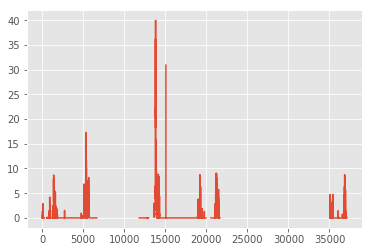

In [96]:
warnings.filterwarnings("ignore",category =RuntimeWarning)
r_file= list(a301.data_dir.glob('*2C-RAIN-PROFILE*hdf'))[2]
rain_rate = HDFvd_read(r_file,'rain_rate',vgroup='Data Fields')
invalid = (rain_rate == -9999.)
rain_rate[invalid] = np.nan
hit = rain_rate < 0.
rain_rate[hit] = np.abs(rain_rate[hit])
plt.plot(rain_rate);

### Creating a masked array of the reflectivity so that pcolormesh will plot it

In [97]:
hit=(radar_reflectivity == radar_missing)
radar_reflectivity=radar_reflectivity.astype(np.float)
radar_reflectivity[hit]=np.nan
zvals = radar_reflectivity/radar_scale
zvals=ma.masked_invalid(zvals)

### Find the part of the Satellite orbiting track that corresponds to the 3 minutes containing the storm

In [98]:
first_time=date_times[0]
print(f'orbit start: {first_time}')
start_hour=19
start_minute=37
storm_start=starttime=dt.datetime(first_time.year,first_time.month,first_time.day,
                                        start_hour,start_minute,0,tzinfo=tz.utc)
#
# get 3 minutes of data from the storm_start
#
storm_stop=storm_start + dt.timedelta(minutes=3)
print(f'storm start: {storm_start}')
time_hit = np.logical_and(date_times > storm_start,date_times < storm_stop)
storm_lats = lats[time_hit]
storm_lons=lons[time_hit]
storm_prof_times=prof_times[time_hit]
storm_zvals=zvals[time_hit,:]
storm_height=radar_height[time_hit,:]
storm_date_times=date_times[time_hit]
rain_rate=rain_rate[time_hit]


orbit start: 2010-09-17 18:41:36.961000+00:00
storm start: 2010-09-17 19:37:00+00:00


### convert time to distance to get the greatcircle distance between shots

In [99]:
great_circle=pyproj.Geod(ellps='WGS84')
distance=[0]
start=(storm_lons[0],storm_lats[0])
for index in np.arange(1,len(storm_lons)):
    azi12,azi21,step= great_circle.inv(storm_lons[index-1],storm_lats[index-1],
                                       storm_lons[index],storm_lats[index])
    distance.append(distance[index-1] + step)
distance=np.array(distance)/meters2km

### Make the plot assuming that height is the same for every shot

* need to customize the subplots to share the x axis between the radar reflectivity and the rain_rate, and adjust the sizes to hold a colorbar

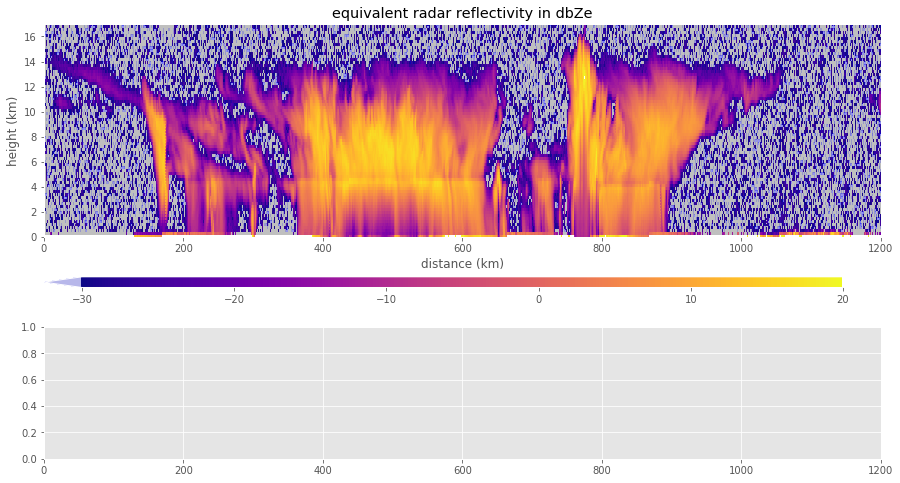

In [100]:
%matplotlib inline

from matplotlib import cm
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_field2(distance,height,field,fig,cmap=None,norm=None):
    """
    draw a 2 panel plot with different panel sizes.  Put the radar reflectivity
    in the top panel with a colorbar along the bottom, and pass the second
    axis back to be filled in later
    
    uses the sharex keyword to give both plots the same x axis (distance) 
    and the gridspec class to lay out the grid
    
    https://stackoverflow.com/questions/10388462/matplotlib-different-size-subplots
    """
    from matplotlib import gridspec
    gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1],sharex=ax1)
    if cmap is None:
        cmap=cm.inferno
    col=ax1.pcolormesh(distance,height,field,cmap=cmap,
                  norm=the_norm)
    #https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
    # create an axes on the bottom side of ax1. The height of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.55 inch.
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("bottom", size="5%", pad=0.55)
    ax1.figure.colorbar(col,extend='both',cax=cax,orientation='horizontal')
    return ax1, ax2

vmin=-30
vmax=20
the_norm=Normalize(vmin=vmin,vmax=vmax,clip=False)
cmap_ref=cm.plasma
cmap_ref.set_over('w')
cmap_ref.set_under('b',alpha=0.2)
cmap_ref.set_bad('0.75') #75% grey

cloud_height_km=radar_height[0,:]/meters2km
fig = plt.figure(figsize=(15, 8)) 
ax1, ax2 = plot_field2(distance,cloud_height_km,storm_zvals.T,fig,cmap=cmap_ref,norm=the_norm)
ax1.set(ylim=[0,17],xlim=(0,1200))
ax1.set(xlabel='distance (km)',ylabel='height (km)',
       title='equivalent radar reflectivity in dbZe');


### Add the rain rate

Use the second axis to draw the rain rate and redraw the figure

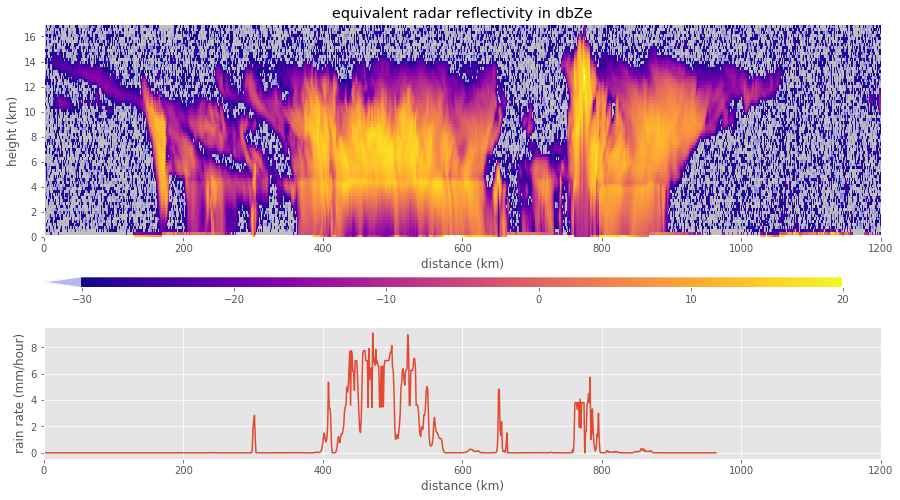

In [101]:
ax2.plot(distance,rain_rate)
ax2.set(xlabel='distance (km)',ylabel='rain rate (mm/hour)')
display(fig)

### Repeat for precipitatable liquid water and retrieval uncertainty

Make a new plot pair -- for variable information see the [dataset docs](http://www.cloudsat.cira.colostate.edu/data-products/level-2c/2c-rain-profile?term=56)

In [102]:
liquid_water, lw_attributes = HDFsd_read(r_file,'precip_liquid_water')
lw_attributes

{'factor': 1000.0,
 'offset': 0.0,
 'long_name': 'Liquid precipitation water content',
 'units': 'g/m3',
 'valid_range': [0, 10000],
 'missing': 28008}

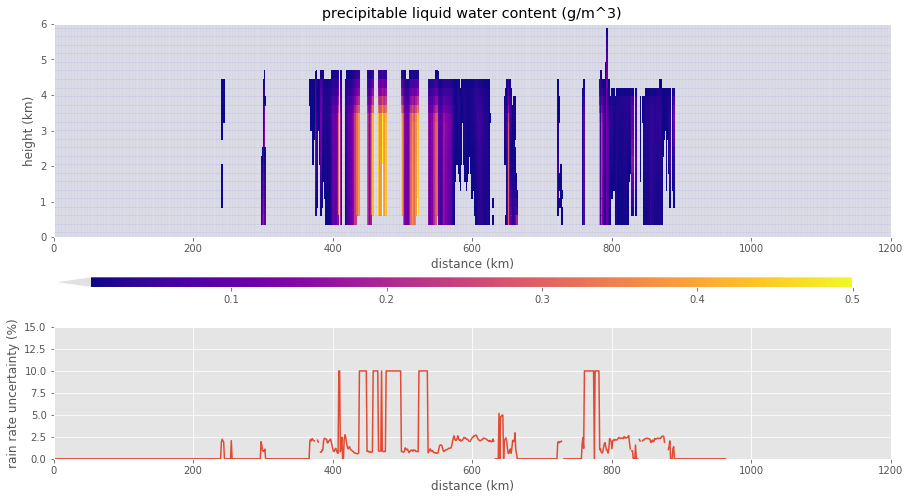

In [103]:
precip_uncertainty = HDFvd_read(r_file,'rain_rate_uncertainty',vgroup='Data Fields')
storm_liquid=liquid_water[time_hit,:]/lw_attributes['factor']
precip_uncert=precip_uncertainty[time_hit]

vmin=0.01
vmax=0.5
the_norm=Normalize(vmin=vmin,vmax=vmax,clip=False)
cmap_ref=cm.plasma
cmap_ref.set_over('w')
cmap_ref.set_under('b',alpha=0.02)
cmap_ref.set_bad('0.75') #75% grey

fig = plt.figure(figsize=(15, 8)) 
ax1, ax2 = plot_field2(distance,cloud_height_km,storm_liquid.T,fig,cmap=cmap_ref,norm=the_norm)
ax1.set(ylim=[0,6],xlim=(0,1200))
ax1.set(xlabel='distance (km)',ylabel='height (km)',
       title='precipitable liquid water content (g/m^3)')
ax2.plot(distance,precip_uncert)
ax2.set(ylim=[0,15],xlabel='distance (km)',ylabel='rain rate uncertainty (%)');

In [104]:
lw_attributes

{'factor': 1000.0,
 'offset': 0.0,
 'long_name': 'Liquid precipitation water content',
 'units': 'g/m3',
 'valid_range': [0, 10000],
 'missing': 28008}

### Get ECMWF temps

In [105]:
z_file= list(a301.data_dir.glob('*ECMWF-AUX_GRANULE*hdf'))[2]
ec_height=HDFvd_read(z_file,'EC_height')
ec_temps, temps_attributes = HDFsd_read(z_file,'Temperature')
ec_missing = temps_attributes['missing']

### Subsetting the ECMWF data

In [106]:
bad_temps = (ec_temps == ec_missing)
ec_temps[bad_temps]=np.nan
ec_temps=np.ma.masked_invalid(ec_temps)
ec_temps = ec_temps - 273.15
ec_temps=ec_temps[time_hit,:]

### ECMWF temperatures for the segment

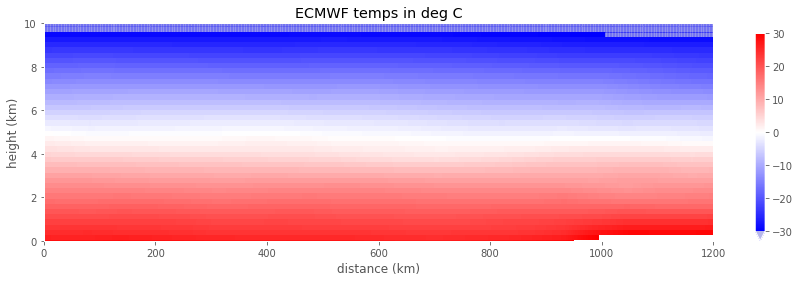

In [107]:
def plot_field(distance,height,field,ax,cmap=None,norm=None):
    """
    given an axis, draw a cloudsat cross section
    """
    if cmap is None:
        cmap=cm.inferno
    col=ax.pcolormesh(distance,height,field,cmap=cmap,
                  norm=the_norm)
    ax.figure.colorbar(col,extend='both',ax=ax)
    return ax

fig, ax =plt.subplots(1,1,figsize=(15,4))
vmin=-30
vmax=30
the_norm=Normalize(vmin=vmin,vmax=vmax,clip=False)
cmap_ec= cm.bwr
cmap_ec.set_over('w')
cmap_ec.set_under('b',alpha=0.2)
cmap_ec.set_bad('0.75') #75% grey

ec_height_km=ec_height/meters2km
ax=plot_field(distance,ec_height_km,ec_temps.T,ax,cmap=cmap_ec,
                  norm=the_norm)
ax.set(ylim=[0,10],xlim=(0,1200))
ax.set(xlabel='distance (km)',ylabel='height (km)',title='ECMWF temps in deg C')
fig.savefig('temps.png')

### Read in heating rate

In [108]:
hr_file= list(a301.data_dir.glob('*FLXHR*hdf'))[2]
lats,lons,date_times,prof_times,dem_elevation=get_geo(hr_file)
lats=lats.squeeze()
lons=lons.squeeze()
qr, qr_attrs = HDFsd_read(hr_file,'QR')
qr_height, height_attrs = HDFsd_read(hr_file,'Height')
factor = HDFvd_read(hr_file,'QR.factor',vgroup='Swath Attributes')[0][0]
missing = HDFvd_read(hr_file,'QR.missing',vgroup='Swath Attributes')[0][0]
units = HDFvd_read(hr_file,'QR.units',vgroup='Swath Attributes')[0][0]
#set_trace()
hit = (qr == missing)
qr = qr.astype(np.float64)/factor
qr[hit]=np.nan


storm_qr=qr[:,time_hit,:]
storm_height=qr_height[time_hit,:]

### Split out the long and shortwave heating rates

In [109]:
shortwave_qr=storm_qr[0,:,:]
longwave_qr=storm_qr[1,:,:]

### Make a plots for shortwave and longwave heating rates

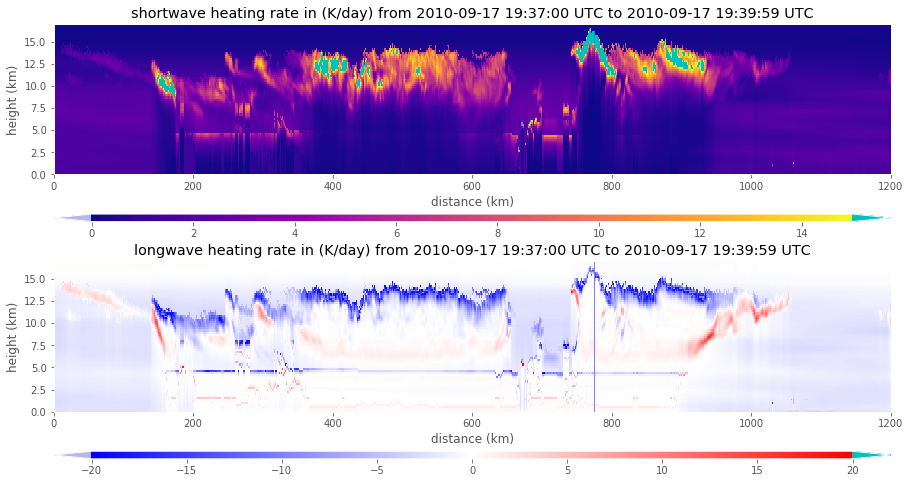

In [110]:
%matplotlib inline

from matplotlib import cm
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_field2(distance,height,field,fig,cmap=None,norm=None):
    """
    draw a 2 panel plot with identical panel sizes.  
    uses the sharex keyword to give both plots the same x axis (distance) 
    and the gridspec class to lay out the grid
    
    https://stackoverflow.com/questions/10388462/matplotlib-different-size-subplots
    """
    from matplotlib import gridspec
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1]) 
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1],sharex=ax1)
    if cmap is None:
        cmap=cm.inferno
    col=ax1.pcolormesh(distance,height,field,cmap=cmap,
                  norm=the_norm)
    #https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
    # create an axes on the bottom side of ax1. The height of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.55 inch.
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("bottom", size="5%", pad=0.55)
    ax1.figure.colorbar(col,extend='both',cax=cax,orientation='horizontal')
    return ax1, ax2

meters2km=1.e3
vmin=0
vmax=15
the_norm=Normalize(vmin=vmin,vmax=vmax,clip=False)
cmap_ref=cm.plasma
cmap_ref.set_over('c')
cmap_ref.set_under('b',alpha=0.2)
cmap_ref.set_bad('0.75') #75% grey
#
#  see http://strftime.org/ for these format strings
#
start_string=storm_date_times[0].strftime("%Y-%m-%d %H:%M:%S UTC")
stop_string=storm_date_times[-1].strftime("%Y-%m-%d %H:%M:%S UTC")

cloud_height_km=qr_height[0,:]/meters2km
fig = plt.figure(figsize=(15, 8)) 
ax1, ax2 = plot_field2(distance,cloud_height_km,shortwave_qr.T,
                       fig,cmap=cmap_ref,norm=the_norm)
ax1.set(ylim=[0,17],xlim=(0,1200))
ax1.set(xlabel='distance (km)',ylabel='height (km)',
       title=f'shortwave heating rate in (K/day) from {start_string} to '
             f'{stop_string}');
vmin=-20
vmax=20.
cmap_ref=cm.bwr
cmap_ref.set_over('c')
cmap_ref.set_under('b',alpha=0.2)
cmap_ref.set_bad('0.75') #75% grey
the_norm=Normalize(vmin=vmin,vmax=vmax,clip=False)
divider = make_axes_locatable(ax2)
cax = divider.append_axes("bottom", size="5%", pad=0.55)
col=ax2.pcolormesh(distance,cloud_height_km,longwave_qr.T,cmap=cmap_ref,
                  norm=the_norm)
ax2.figure.colorbar(col,extend='both',cax=cax,orientation='horizontal')
title = (f'longwave heating rate in (K/day) from {start_string} to '
         f'{stop_string}')
ax2.set(xlabel='distance (km)',ylabel='height (km)',title=title,ylim=[0,17]);